#***Project: Liver Cancer Image Segregation Model***

#***DATASET COLLECTION***

https://www.kaggle.com/datasets/muayad/liver-tumor-segmentation?select=train

Install &  Import Required Libraries

In [11]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt


#***DATA PREPROCESSING & SPLITTING***


Load dataset

In [13]:
data_dir='D:/Rijab/.vscode/Repos/Machine-Learning-Projects/dataset/liver_png'

# Load and preprocess data
def load_data(data_dir):
    train_data = []
    test_data = []
    for folder in os.listdir(data_dir):
        if folder == 'train':
            for class_folder in os.listdir(os.path.join(data_dir, folder)):
                if class_folder == 'class1':
                    for file in os.listdir(os.path.join(data_dir, folder, class_folder)):
                        img_path = os.path.join(data_dir, folder, class_folder, file)
                        img = tf.io.read_file(img_path)
                        img = tf.image.decode_jpeg(img)
                        img = tf.image.resize(img, (112, 112))
                        train_data.append(img)
                        test_data.append(0)
                elif class_folder == 'class2':
                    for file in os.listdir(os.path.join(data_dir, folder, class_folder)):
                        img_path = os.path.join(data_dir, folder, class_folder, file)
                        img = tf.io.read_file(img_path)
                        img = tf.image.decode_jpeg(img)
                        img = tf.image.resize(img, (112, 112))
                        train_data.append(img)
                        test_data.append(1)
        elif folder == 'test':
            for class_folder in os.listdir(os.path.join(data_dir, folder)):
                if class_folder == 'class1':
                    for file in os.listdir(os.path.join(data_dir, folder, class_folder)):
                        img_path = os.path.join(data_dir, folder, class_folder, file)
                        img = tf.io.read_file(img_path)
                        img = tf.image.decode_jpeg(img)
                        img = tf.image.resize(img, (112, 112))
                        train_data.append(img)
                        test_data.append(0)
                elif class_folder == 'class2':
                    for file in os.listdir(os.path.join(data_dir, folder, class_folder)):
                        img_path = os.path.join(data_dir, folder, class_folder, file)
                        img = tf.io.read_file(img_path)
                        img = tf.image.decode_jpeg(img)
                        img = tf.image.resize(img, (112, 112))
                        train_data.append(img)
                        test_data.append(1)

    # Convert to numpy arrays
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    return train_data, test_data

train_data, test_data = load_data(data_dir)  # Load both images and labels

In [14]:
print(train_data.shape, test_data.shape)

(3138, 112, 112, 3) (3138,)


Preprocess Dataset

In [15]:
def preprocess_data(images, labels):
    # Resize the images array to match the desired shape
    import cv2
    images = np.array([cv2.resize(img, (112, 112)) for img in images])  # Resize each image to (112, 112)
    images = images.astype(np.float32)  # Use float32 instead of float64
    labels = np.pad(labels, ((0, 3138 - labels.shape[0]),))
    # Convert labels to categorical
    labels = to_categorical(labels, num_classes=2)

    return images, labels

images, labels = preprocess_data(train_data, test_data)
# Split data into training, validation, and testing sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Train images shape: (2102, 112, 112, 3)
Train labels shape: (2102, 2)
Validation images shape: (1036, 112, 112, 3)
Validation labels shape: (1036, 2)


#***U-NET MODEL ARCHITECTURE***

In [16]:
def unet_model(input_size=(112, 112, 3)):
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(pool4)
    conv5 = keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(conv5)

    up6 = keras.layers.Conv2D(256, (2,2), activation='relu', padding='same')(keras.layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = keras.layers.Concatenate()([conv4, up6])
    conv6 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(merge6)
    conv6 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(conv6)

    up7 = keras.layers.Conv2D(128, (2,2), activation='relu', padding='same')(keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = keras.layers.Concatenate()([conv3, up7])
    conv7 = keras.layers.Conv2D(128,(3,3), activation='relu', padding='same')(merge7)
    conv7 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv7)

    up8 = keras.layers.Conv2D(64, (2,2), activation='relu', padding='same')(keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = keras.layers.Concatenate()([conv2, up8])
    conv8 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(merge8)
    conv8 = keras.layers.Conv2D(64,(3,3), activation='relu', padding='same')(conv8)

    up9 = keras.layers.Conv2D(32, (2,2), activation='relu', padding='same')(keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = keras.layers.Concatenate()([conv1, up9])
    conv9 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(merge9)
    conv9 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv9)

    flatten = keras.layers.Flatten()(conv9)
    output = keras.layers.Dense(2, activation='softmax')(flatten)

    return keras.Model(inputs=inputs, outputs=output)

#***MODEL COMPILATION & TRAINING***

In [17]:

print("Labels shape:", labels.shape)
print("Val labels shape:", val_labels.shape)

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
# Define the batch size and chunk size
batch_size = 32
chunk_size = 1000

# Create a dataset pipeline with batching and chunking
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(chunk_size)

# Create a validation dataset pipeline
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(chunk_size)


Labels shape: (3138, 2)
Val labels shape: (1036, 2)


In [21]:
# # Define the model and compile it
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(dataset, epochs=10, validation_data=val_dataset, verbose=1)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1381s 14s/step - accuracy: 0.9287 - loss: 808660.6250 - val_accuracy: 0.3292 - val_loss: 10.5846
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1319s 13s/step - accuracy: 0.7777 - loss: 3.5630 - val_accuracy: 0.3292 - val_loss: 5296.0708
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1491s 15s/step - accuracy: 0.5967 - loss: 422.8735 - val_accuracy: 0.3292 - val_loss: 54.6514
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1462s 15s/step - accuracy: 0.7787 - loss: 5.5312 - val_accuracy: 0.3292 - val_loss: 8.1803
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1822s 18s/step - accuracy: 0.4902 - loss: 1.8505 - val_accuracy: 0.3292 - val_loss: 741.9631
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1915s 19s/step - accuracy: 0.8255 - loss: 46.9515 - val_accuracy: 0.6100 - val_loss: 0.6873
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1411s 14s/step - accuracy: 0.8653 - loss: 0.6558 - val_accuracy: 0.6573 - val_loss: 0.6809
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1008s 10s/step - accuracy: 0.8763 - loss: 0.

In [22]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 7, 7, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 14, 14,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │    524,544 │ up_sampling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,688,648 (97.99 MB)

 Trainable params: 8,562,882 (32.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,125,766 (65.33 MB)

None


#***SEGMENTED TUMOR IMAGES & TEST ACCURACY***

In [68]:
from skimage.filters import threshold_otsu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


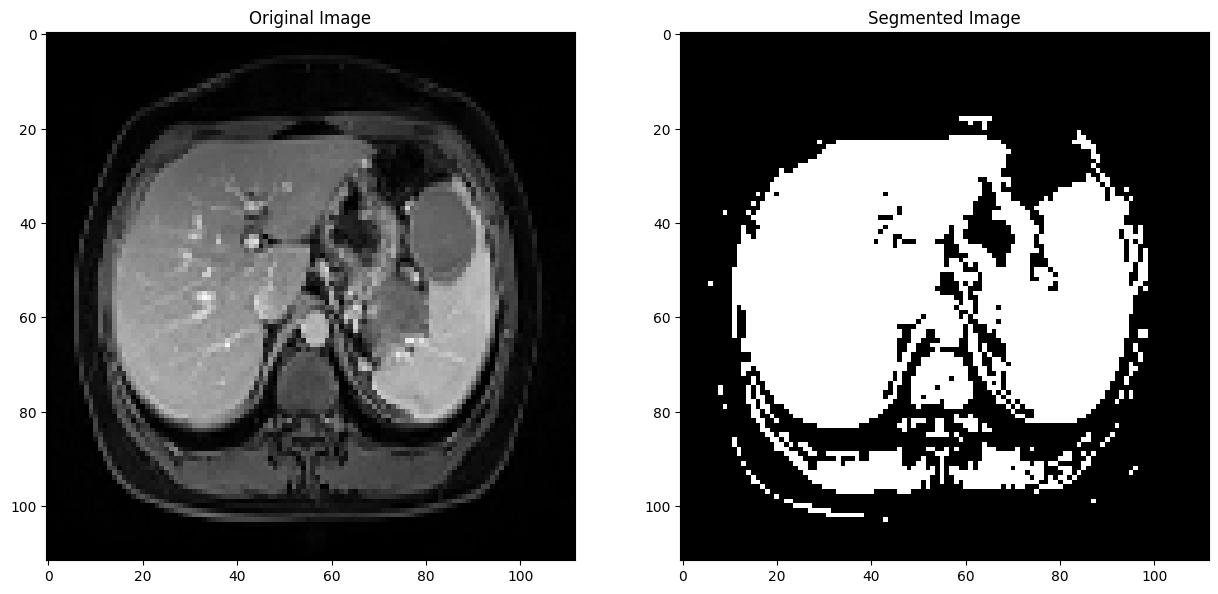

33/33 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.6983 - loss: 0.6507


In [69]:
labels = np.array(images)

# Pad to the desired shape
desired_shape = (1, 112, 112, 3)  # If images are RGB
padded_labels = np.zeros(desired_shape, dtype=np.uint8)  # Ensure appropriate data type
padded_labels.flat[:labels.size] = labels
labels = padded_labels

# Predict on test data (assuming you have a model called 'model')
test_pred = model.predict(labels)

# Convert to grayscale for thresholding
gray_image = np.mean(labels, axis=3)

# Apply Otsu's thresholding
thresh = threshold_otsu(gray_image)
test_pred = gray_image > thresh

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
for i in range(min(5, len(test_pred))):
    axs[0].imshow(labels[i], cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(test_pred[i], cmap='gray')
    axs[1].set_title('Segmented Image')
plt.show()
    
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(val_images, val_labels)
test_acc=(test_acc*100)
test_loss=(test_loss/100)


In [70]:
# Calculate Dice similarity coefficient
def dice_similarity_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()[:, np.newaxis]  # Reshape y_pred_f to make it compatible for broadcasting
    
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

# Flatten test_pred_binary to a 1D array
test_pred_binary_flat = test_pred.flatten()

dice_coeff = dice_similarity_coefficient(val_labels, test_pred)
print(f'Dice similarity coefficient: {(dice_coeff/100):2f}')

# Calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

# Resample test_pred_binary to match the number of samples in val_labels
test_pred_binary_resampled = np.random.choice(test_pred_binary_flat, size=len(val_labels), replace=True)
val_labels_binary = np.argmax(val_labels, axis=1)  # Convert multilabel-indicator to binary target
precision = precision_score(val_labels_binary, test_pred_binary_resampled)
recall = recall_score(val_labels_binary, test_pred_binary_resampled)
f1 = f1_score(val_labels_binary, test_pred_binary_resampled)

print(f'Precision: {(precision*100):2f}')
print(f'Recall: {(recall*100):2f}')
print(f'F1 score: {(f1*100):2f}')

print(f'Test accuracy: {test_acc:.3f}')

Dice similarity coefficient: 16.763878
Precision: 35.294118
Recall: 35.190616
F1 score: 35.242291
Test accuracy: 67.085


#***PLOTING THE RESULTS***

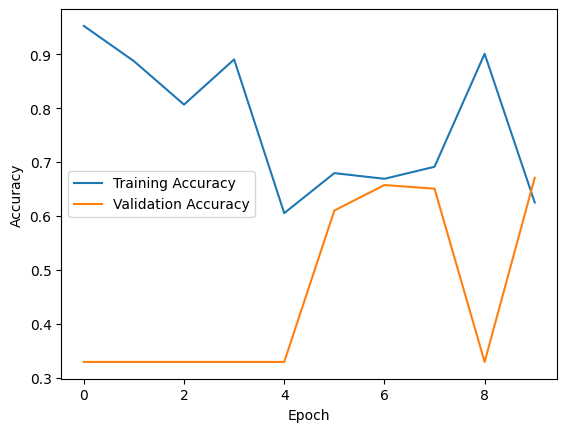

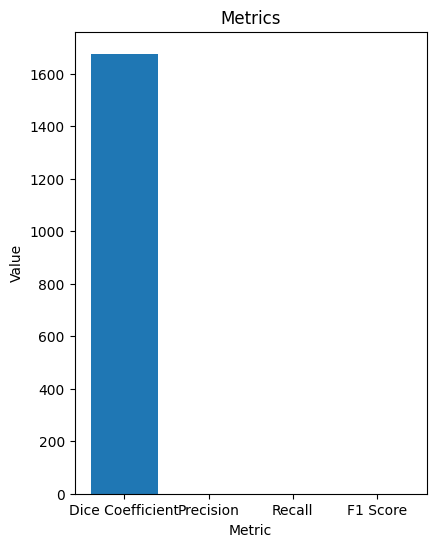

In [71]:
# Plot the results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the metrics
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.bar(['Dice Coefficient', 'Precision', 'Recall', 'F1 Score'], [dice_coeff, precision, recall, f1])
plt.title('Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

plt.show()